In [55]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# Fetch Inflation data using FRED Public Data API

In [62]:
# Import or assign API key
api_key = "58394c9866a5e8ff6f27cbd23af8e6f7"

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

'''
Get observation data from the FRED API
'''

# Assign endpoint
obs_endpoint = 'series/observations'

# Assign parameters
series_id = 'T10YIE'   #FEDFUNDS
start_date = '1999-01-01'
end_date = '2024-01-31'
#ts_frequency = 'm'
#ts_units = 'pc1'

obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
    obs_data['Year']=obs_data['date'].dt.year
    obs_data['Month']=obs_data['date'].dt.month
    obs_data.set_index('date', inplace=True)
    obs_data['Inflation'] = obs_data['value']#.astype(float)
    obs_data = obs_data.drop(columns=["realtime_start", "realtime_end","value"])

else:
    print('Failed to retrieve data. Status code:', response.status_code)

# DATA WRANGLING TO REMOVE "." FROM INFLATION DATASET

In [63]:
obs_data.Inflation = pd.to_numeric(obs_data['Inflation'], errors='coerce')
obs_data.head(30),obs_data.shape,obs_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5500 entries, 2003-01-02 to 2024-01-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       5500 non-null   int32  
 1   Month      5500 non-null   int32  
 2   Inflation  5275 non-null   float64
dtypes: float64(1), int32(2)
memory usage: 128.9 KB


(            Year  Month  Inflation
 date                              
 2003-01-02  2003      1       1.64
 2003-01-03  2003      1       1.62
 2003-01-06  2003      1       1.63
 2003-01-07  2003      1       1.62
 2003-01-08  2003      1       1.71
 2003-01-09  2003      1       1.78
 2003-01-10  2003      1       1.75
 2003-01-13  2003      1       1.77
 2003-01-14  2003      1       1.76
 2003-01-15  2003      1       1.80
 2003-01-16  2003      1       1.79
 2003-01-17  2003      1       1.80
 2003-01-20  2003      1        NaN
 2003-01-21  2003      1       1.78
 2003-01-22  2003      1       1.72
 2003-01-23  2003      1       1.78
 2003-01-24  2003      1       1.80
 2003-01-27  2003      1       1.82
 2003-01-28  2003      1       1.81
 2003-01-29  2003      1       1.85
 2003-01-30  2003      1       1.80
 2003-01-31  2003      1       1.81
 2003-02-03  2003      2       1.81
 2003-02-04  2003      2       1.84
 2003-02-05  2003      2       1.90
 2003-02-06  2003      2    

In [64]:
obs_data['Inflation'] = obs_data['Inflation'].replace(np.NaN,0)
obs_data = obs_data[obs_data['Inflation'] != 0.00]
obs_data.head(30),obs_data.shape

(            Year  Month  Inflation
 date                              
 2003-01-02  2003      1       1.64
 2003-01-03  2003      1       1.62
 2003-01-06  2003      1       1.63
 2003-01-07  2003      1       1.62
 2003-01-08  2003      1       1.71
 2003-01-09  2003      1       1.78
 2003-01-10  2003      1       1.75
 2003-01-13  2003      1       1.77
 2003-01-14  2003      1       1.76
 2003-01-15  2003      1       1.80
 2003-01-16  2003      1       1.79
 2003-01-17  2003      1       1.80
 2003-01-21  2003      1       1.78
 2003-01-22  2003      1       1.72
 2003-01-23  2003      1       1.78
 2003-01-24  2003      1       1.80
 2003-01-27  2003      1       1.82
 2003-01-28  2003      1       1.81
 2003-01-29  2003      1       1.85
 2003-01-30  2003      1       1.80
 2003-01-31  2003      1       1.81
 2003-02-03  2003      2       1.81
 2003-02-04  2003      2       1.84
 2003-02-05  2003      2       1.90
 2003-02-06  2003      2       1.88
 2003-02-07  2003      2    

In [65]:
df_inf = obs_data.groupby(['Year', 'Month'])['Inflation'].mean().reset_index()
df_inf['date'] = pd.to_datetime(dict(year=df_inf.Year, month=df_inf.Month, day=1))

In [66]:
df_inf =df_inf[['date','Inflation']].set_index('date')

In [67]:
df_inf.sort_values(by='date',inplace=True)

# Holt Winter's Exponential Smoothing

In [68]:
# Import packages
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

In [69]:
def hyperparameter_tuning_season_cv(n_splits: int,var,
                                    gammas: list[float],
                                    df: pd.DataFrame) -> pd.DataFrame:
    """Function to carry out cross-validation hyperparameter tuning
    for the seasonal parameter in a Holt Winters' model. """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    error_list = []
    forecast_list = []
    gamma_list  = []

    for gamma in gammas:

        errors = []

        for train_index, valid_index in tscv.split(df):
            train, valid = df.iloc[train_index], df.iloc[valid_index]

            model = ExponentialSmoothing(train[var], trend='mul',
                                         seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=gamma)

            forecasts = model.forecast(len(valid))
            errors.append(mean_absolute_percentage_error(valid[var], forecasts))

        error_list.append([gamma, sum(errors) / len(errors)])
        forecast_list.append(forecasts)
        gamma_list.append(gamma)

    return pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])


def plot_error_cv(df: pd.DataFrame,title: str) -> None:
    """Bar chart to plot the errors from the different
    hyperparameters."""

    fig = px.bar(df, x='Gamma', y='MAPE')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400)
    df_smooth = df[df.MAPE==df.MAPE.min()]
    smooth_factor = df_smooth.Gamma
    print('Smoothing Factor: ',smooth_factor)

    return fig.show(),smooth_factor

#Predict Unemployment Rate

In [70]:
# Carry out cv for hyperparameter tuning for the seasonal parameter
error_df = hyperparameter_tuning_season_cv(df=df_inf,n_splits=4,var='Inflation',gammas=list(np.arange(0, 1.1, 0.1)))

# Plot the tuning results to view the best smoothing constant
plot,smooth = plot_error_cv(df=error_df, title='Hyperparameter Results')

#Build an Exponential model with the best smoothing constant (0.5)
model2 = ExponentialSmoothing(df_inf['Inflation'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

Smoothing Factor:  9    0.9
Name: Gamma, dtype: float64


In [71]:
  # Split train and test
train = df_inf.iloc[:-12]
print('Train size: ', len(train))
test = df_inf.iloc[-12:]
print('Test size: ',len(test))

Train size:  241
Test size:  12


In [72]:
# Build model and make prediction
col = ['Inflation']
model = ExponentialSmoothing(train['Inflation'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
predictions = model.forecast(steps=len(test))
pred =  pd.DataFrame(predictions).set_index(test.index)
pred.columns = col
residuals = test['Inflation'] - pred['Inflation']
print(pred)

            Inflation
date                 
2023-02-01   2.398650
2023-03-01   2.745869
2023-04-01   2.758515
2023-05-01   2.570681
2023-06-01   2.483031
2023-07-01   2.245323
2023-08-01   2.370064
2023-09-01   2.252096
2023-10-01   2.274400
2023-11-01   2.264879
2023-12-01   2.163750
2024-01-01   2.280540


Text(0, 0.5, 'Error')

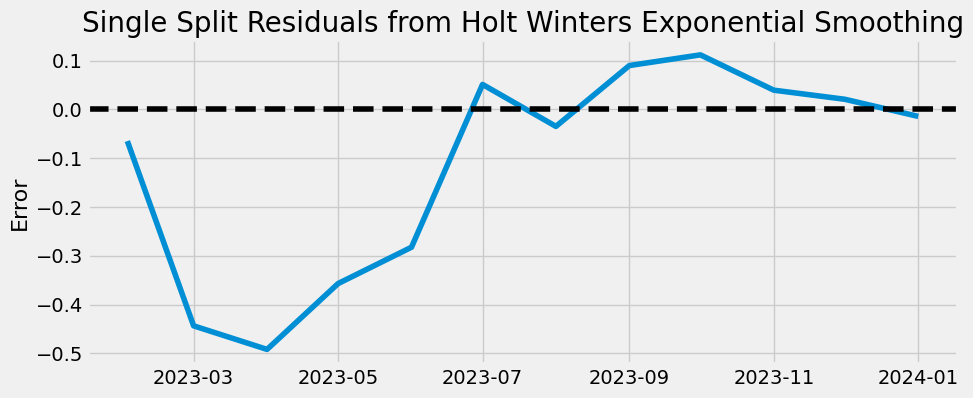

In [73]:
# Display Residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Single Split Residuals from Holt Winters Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0.5, 1.0, 'INFLATION RATE')

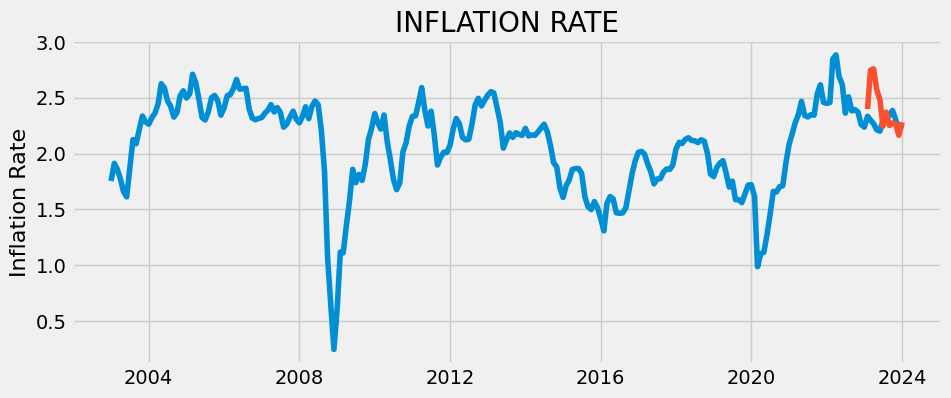

In [74]:
# Display original dataset and prediction
plt.figure(figsize=(10,4))
plt.plot(df_inf)
plt.plot(pred)
plt.ylabel('Inflation Rate', fontsize=16)
plt.title('INFLATION RATE', fontsize=20)

In [75]:
# Calculate MAPE
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['Inflation']*100)),4))

Mean Absolute Percent Error: 7.356


In [76]:
# Calculate RMSE
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.23753701433958732


# Rolling Forecast Origin - Holt Winter Exponential Smoothing

In [77]:
rolling_predictions = test.copy()
pred_list = []
for train_end in test.index:
  train_data = df_inf[:train_end-timedelta(days=1)]
  model = ExponentialSmoothing(train_data['Inflation'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
  pred = model.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

2024-01-01    2.110439
Freq: MS, dtype: float64


In [78]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [79]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test.index,inplace=True)

In [80]:
rolling_residuals = test['Inflation'] - prediction['pred_var']

In [81]:
prediction.sort_values(by='date',inplace=True)

Text(0, 0.5, 'Error')

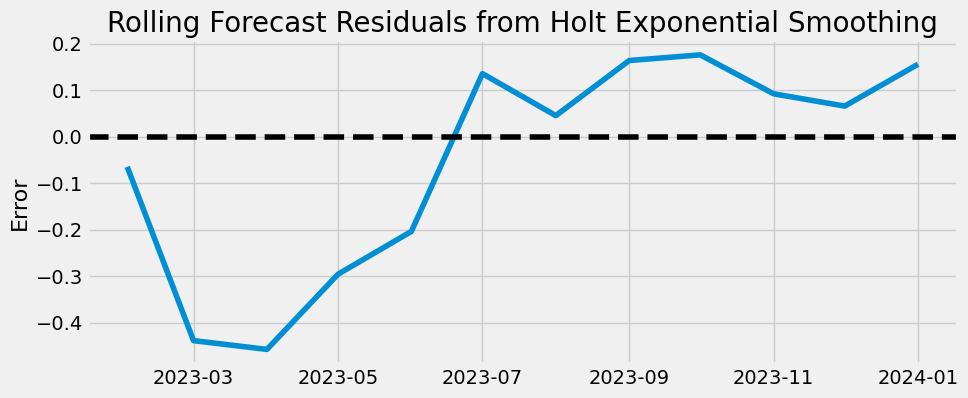

In [82]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from Holt Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [83]:
start_date = datetime(2023,4,1)
end_date = datetime(2024,3,1)

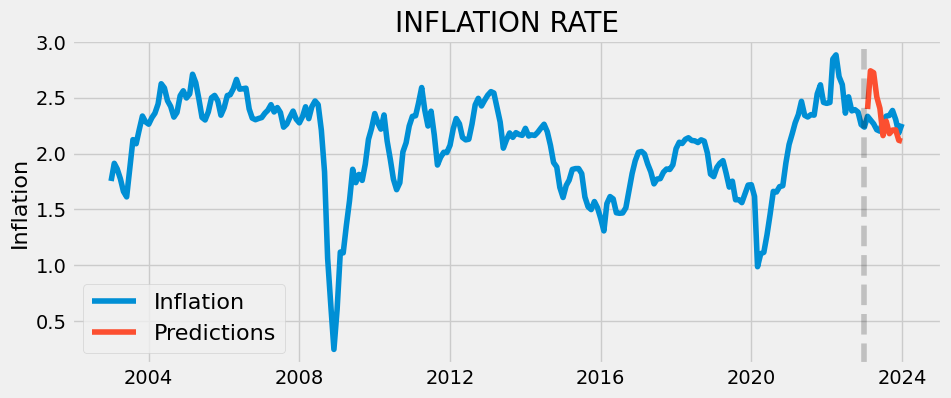

In [84]:
plt.figure(figsize=(10,4))

plt.plot(df_inf)
plt.plot(prediction['pred_var'])
plt.legend(('Inflation', 'Predictions'), fontsize=16)
plt.title('INFLATION RATE', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [85]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test['Inflation']*100)),4))

Mean Absolute Percent Error: 8.3968


In [86]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.2328892718468471


# Forcasting the future

In [87]:
#Build an Exponential model with the best smoothing constant
model2 = ExponentialSmoothing(df_inf['Inflation'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

In [88]:
#Six (6) months future projection
future1 = pd.date_range('2024-02-01','2024-12-31', freq='MS')
col = ['Inflation']

In [89]:
df_inf['Inflation'].tail()

date
2023-09-01    2.342000
2023-10-01    2.386190
2023-11-01    2.304286
2023-12-01    2.184500
2024-01-01    2.266190
Name: Inflation, dtype: float64

In [90]:
predictions = model2.forecast(steps=11)
pred =  pd.DataFrame(predictions).set_index(future1)
pred.columns = col

In [91]:
pred

,Inflation
2024-02-01,2.211314
2024-03-01,2.220132
2024-04-01,2.209113
2024-05-01,2.164884
2024-06-01,2.158621
2024-07-01,2.230451
2024-08-01,2.268994
2024-09-01,2.261664
2024-10-01,2.293456
2024-11-01,2.211970


Text(0.5, 1.0, 'INFLATION RATE')

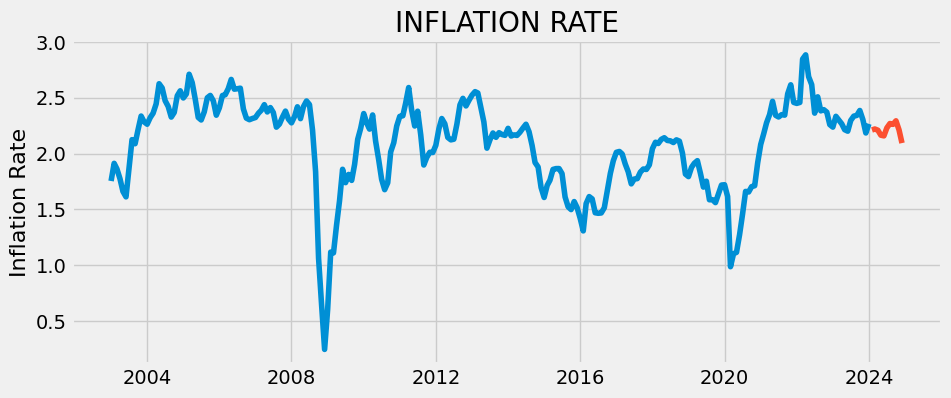

In [92]:
plt.figure(figsize=(10,4))
plt.plot(df_inf)
plt.plot(pred)
plt.ylabel('Inflation Rate', fontsize=16)
plt.title('INFLATION RATE', fontsize=20)

# **Holt's Exponential Smoothing**

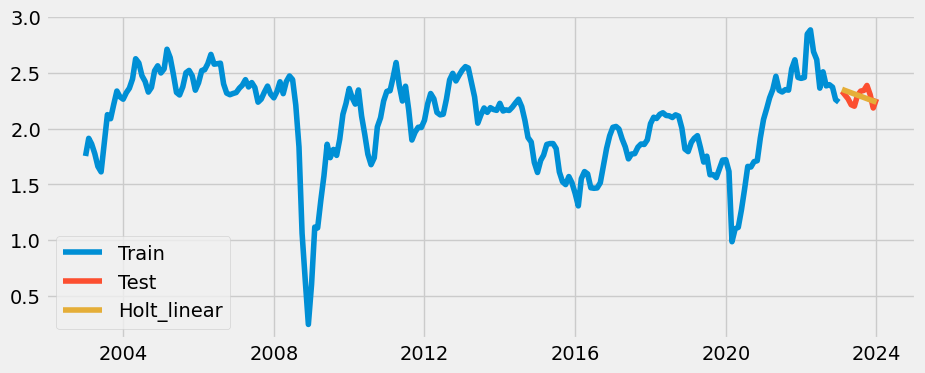

In [93]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit1 = Holt(np.asarray(train['Inflation'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))
residualsHolt = test['Inflation'] - y_hat_avg['Holt_linear']
plt.figure(figsize=(10,4))
plt.plot(train['Inflation'], label='Train')
plt.plot(test['Inflation'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

Text(0, 0.5, 'Error')

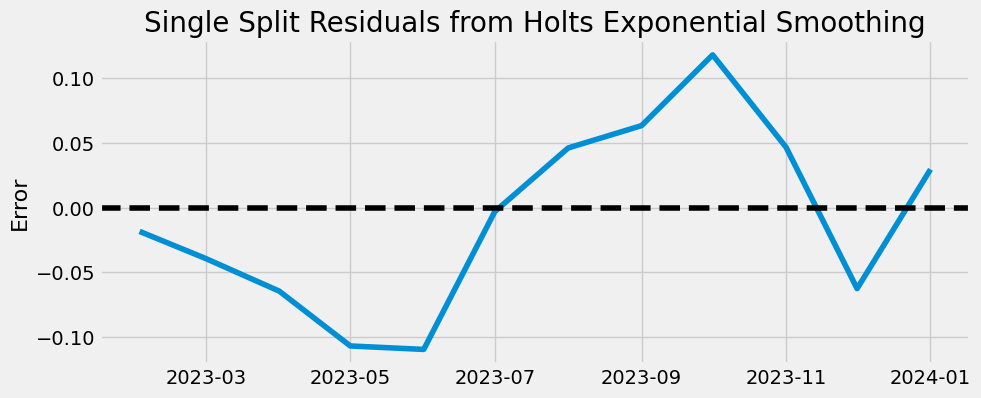

In [94]:
plt.figure(figsize=(10,4))
plt.plot(residualsHolt)
plt.axhline(0, linestyle='--', color='k')
plt.title('Single Split Residuals from Holts Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [95]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residualsHolt/test['Inflation']*100)),4))

Mean Absolute Percent Error: 2.5924


In [96]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residualsHolt**2)))

Root Mean Squared Error: 0.06865091334386218


# Rolling Forecast Origin - Holt's Exponential Smoothing

In [97]:
rolling_predictionsHolts = test.copy()
pred_list = []
for train_end in test.index:
  train_data = df_inf[:train_end-timedelta(days=1)]
  fit1 = Holt(np.asarray(train['Inflation'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
  pred = fit1.forecast()
  pred_list.append(pred)
prediction = pd.DataFrame(pred_list)

In [98]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [99]:
col3 = ['pred_var']
prediction.columns = col3
prediction.set_index(test.index,inplace=True)

In [100]:
residualsHoltRolling = test['Inflation'] - prediction['pred_var']

In [101]:
prediction.sort_values(by='date',inplace=True)

Text(0, 0.5, 'Error')

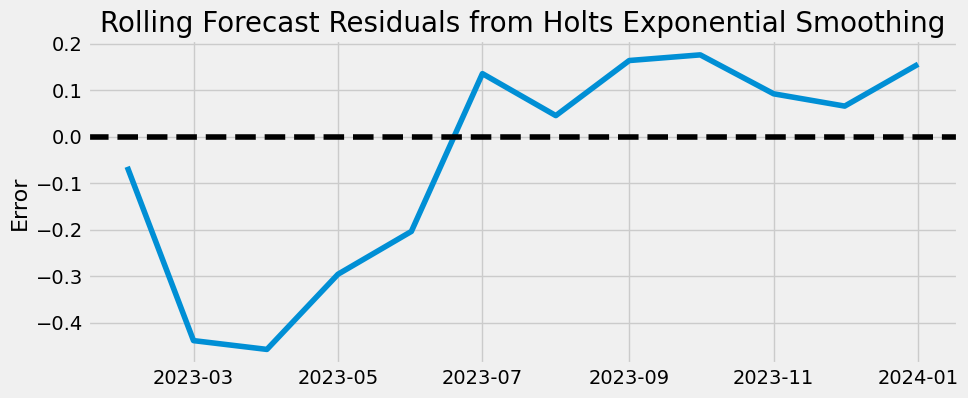

In [102]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from Holts Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [103]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residualsHoltRolling/test['Inflation']*100)),4))

Mean Absolute Percent Error: 3.1951


In [104]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residualsHoltRolling**2)))

Root Mean Squared Error: 0.08870733272480756


# Forcasting the future with Holt Exponential Smoothing

In [105]:
#Build an Exponential model with the best smoothing constant
fit1 = Holt(np.asarray(train['Inflation'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)

In [106]:
#Six (6) months future projection
future02 = pd.date_range('2024-02-01','2024-12-31', freq='MS')
col = ['Inflation']

In [107]:
predictions = fit1.forecast(steps=11)
pred =  pd.DataFrame(predictions).set_index(future02)
pred.columns = col

Text(0.5, 1.0, 'INFLATION RATE')

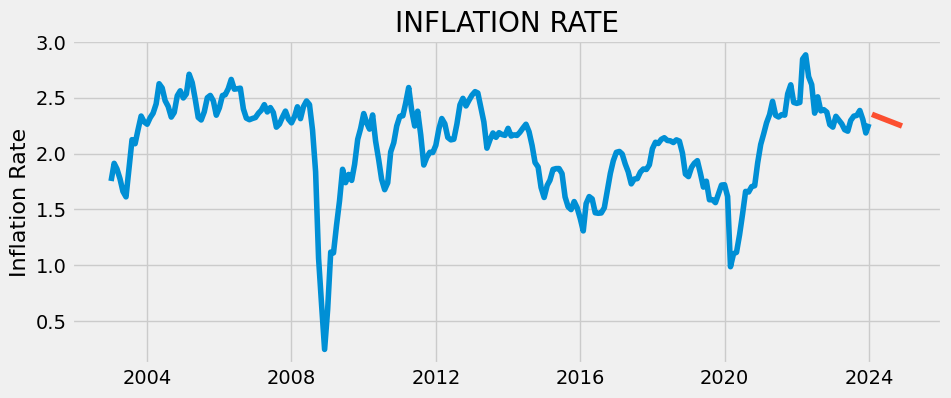

In [108]:
plt.figure(figsize=(10,4))
plt.plot(df_inf)
plt.plot(pred)
plt.ylabel('Inflation Rate', fontsize=16)
plt.title('INFLATION RATE', fontsize=20)